In [3]:
import os, sys, pdb
from pathlib import Path
import pandas as pd
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import time
import copy
import gc
%matplotlib inline
%load_ext autoreload
%autoreload 2
DATA_DIR = Path('../input')
MODEL_DIR = Path('../model')
OUT_DIR = Path('../output')
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import librosa
sr = 2000

In [5]:
training_a = DATA_DIR / 'cinc' / 'training-a'
with open(training_a / 'a0001.hea', 'r') as f:
    head_ex = f.read()

In [6]:
head_ex.split('\n')

['a0001 2 2000 71332',
 'a0001.wav 16+44 1 16 0 0 0 0 PCG',
 'a0001.dat 16 1000 16 0 0 367 0 ECG',
 '# Abnormal',
 '']

In [7]:
head_ex.split('\n')[3].replace('# ', '')

'Abnormal'

In [8]:
wav_file = head_ex.split('\n')[1].split(' ')[0]
ecg_file = head_ex.split('\n')[2].split(' ')[0]

In [9]:
wave, sr = librosa.core.load(training_a / wav_file, sr=sr)
wave.shape[0]

71332

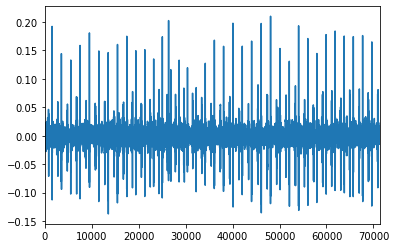

In [10]:
pd.Series(wave).plot()

In [11]:
from ml.src.signal_processor import cwt, to_spect, logmel

In [12]:
import matplotlib.pyplot as plt
from scipy import signal
import seaborn as sns

In [13]:
%reload_ext autoreload

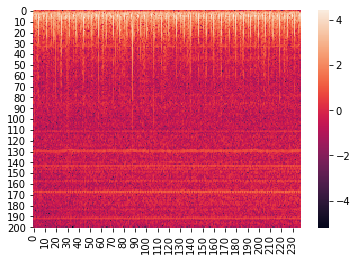

In [15]:
y = to_spect(wave.reshape((1, -1)), sr=sr, window_size=0.2, window_stride=0.15, window='hamming')[0]
y = (y - y.mean()).div(y.std()).transpose(0, 1)
sns.heatmap(y.numpy())

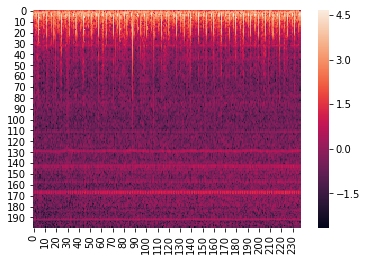

In [16]:
y = logmel(wave.reshape((1, -1)), sr=sr, window_size=0.2, window_stride=0.15, window='hamming', n_mels=200)[0]
y = (y - y.mean()).div(y.std()).transpose(0, 1)
sns.heatmap(y.numpy())

In [17]:
with open(training_a / 'a0007.hea', 'r') as f:
    head_ex = f.read()
print(head_ex.split('\n')[3].replace('# ', ''))
wav_file = head_ex.split('\n')[1].split(' ')[0]
wave, sr = librosa.core.load(training_a / wav_file, sr=sr)
wave.shape[0]

Normal


71332

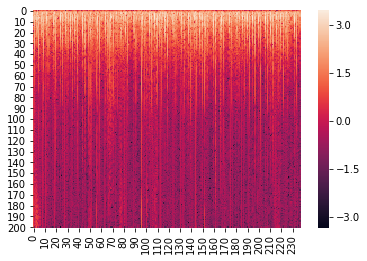

In [19]:
y = to_spect(wave.reshape((1, -1)), sr=sr, window_size=0.2, window_stride=0.15, window='hamming')[0]
y = (y - y.mean()).div(y.std()).transpose(0, 1)
sns.heatmap(y.numpy())

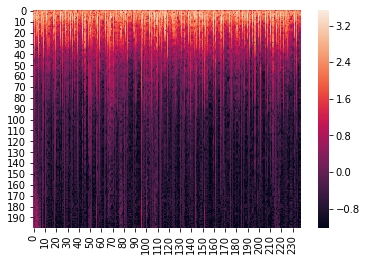

In [20]:
y = logmel(wave.reshape((1, -1)), sr=sr, window_size=0.2, window_stride=0.15, window='hamming', n_mels=200)[0]
y = (y - y.mean()).div(y.std()).transpose(0, 1)
sns.heatmap(y.numpy())

## どうやって時間の違う音声を入力するか。一旦paddingする

In [21]:
SR = sr
ONE_AUDIO_SEC = 60
def pad(wave):
    const_length = SR * ONE_AUDIO_SEC
#     wave = load(path[0], sr=SR)[0]
    if wave.shape[0] > const_length:
        wave = wave[:const_length]
    elif wave.shape[0] < const_length:
        n_pad = (const_length - wave.shape[0]) // 2 + 1
        wave = np.pad(wave[:const_length], n_pad)[:const_length]
    return wave.reshape((1, -1))

In [22]:
_ = pad(wave)
_.shape

(1, 120000)

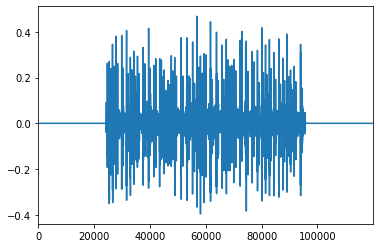

In [23]:
pd.Series(_[0]).plot()

In [24]:
head_paths = []
wav_paths = []
training_folders = [path.resolve() for path in (DATA_DIR / 'cinc').iterdir() if path.name.startswith('training-')]
for training_folder in training_folders:
    head_paths.extend([p for p in training_folder.iterdir() if p.name.endswith('.hea')])
    wav_paths.extend([p for p in training_folder.iterdir() if p.name.endswith('.wav')])
head_paths.sort()
wav_paths.sort()

In [29]:
labels = []
length = []
for head, wav in zip(head_paths, wav_paths):
    assert head.name[:-4] == wav.name[:-4]
    with open(head, 'r') as f:
        labels.append(f.read().split('# ')[-1].replace('\n', ''))
    length.append(librosa.load(wav, sr=sr)[0].shape[0] / sr)

In [31]:
pd.Series(length).describe()

count    3240.000000
mean       22.461753
std        12.386393
min         5.305500
25%        12.899250
50%        20.828500
75%        30.581000
max       121.998500
dtype: float64

In [26]:
manifest = pd.DataFrame([wav_paths, labels]).T
manifest.to_csv(DATA_DIR / 'cinc_manifest.csv', header=None, index=False)